<!-- ## Analyze single `trx.mat` file to generate analyzed HDF5 file required for plotting -->

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from datetime import datetime

# Set matplotlib style
%matplotlib widget
%load_ext autoreload
%autoreload 2
plt.style.use('../anemotaxis.mplstyle')

In [2]:
# Add the project root directory to Python path
project_root = os.path.dirname(os.path.dirname(os.path.abspath('')))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [3]:
import core.data_loader as data_loader
import core.data_processor as data_processor
import viz.plot_data as plot_data
import utils.preprocessing as preprocessing

In [4]:
single_path = "/Users/sharbat/Projects/anemotaxis/data/FCF_attP2-40@UAS_TNT_2_0003/p_5gradient2_2s1x600s0s#n#n#n/20240223_112627/trx.mat"
trx_data = data_loader.load_single_trx_file(single_path, show_progress=True)


Processing file: /Users/sharbat/Projects/anemotaxis/data/FCF_attP2-40@UAS_TNT_2_0003/p_5gradient2_2s1x600s0s#n#n#n/20240223_112627/trx.mat
Number of larvae: 41


Processing larvae:   0%|          | 0/41 [00:00<?, ?it/s]

In [5]:
# Get the parent directory of single_path and create analyses folder if it doesn't exist
# this is to save analysis results and figures if needed
parent_dir = os.path.dirname(single_path)
output_dir = os.path.join(parent_dir, 'analyses')
os.makedirs(output_dir, exist_ok=True)

<!-- ## Ethogram (unfiltered)
1. Run - black
2. Cast - Red
3. Stop - Green
4. Hunch - Blue
5. Backup - Cyan
6. Roll - Yellow -->

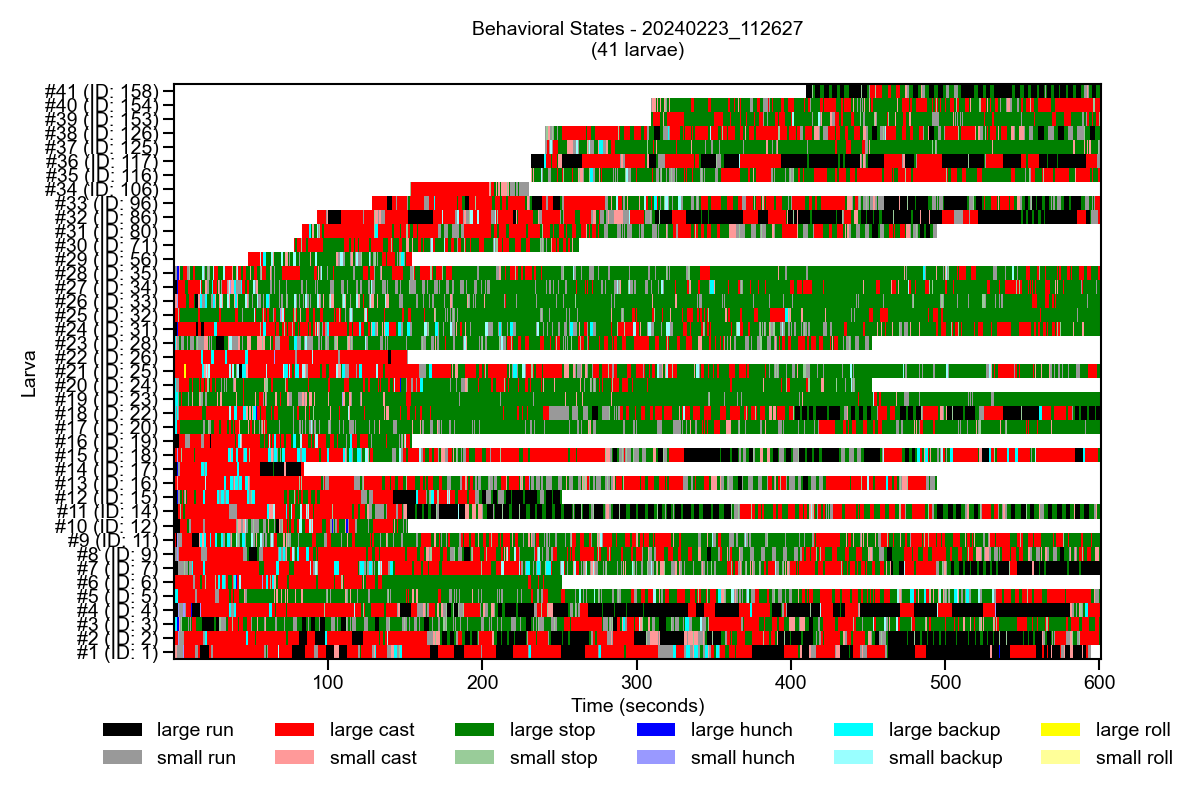

In [6]:
results_behavior_matrix = plot_data.plot_global_behavior_matrix(trx_data)

Duration filtering results (threshold: 300.0s):
  - Removed 11 larvae with <300.0s total duration
  - 30 larvae remaining


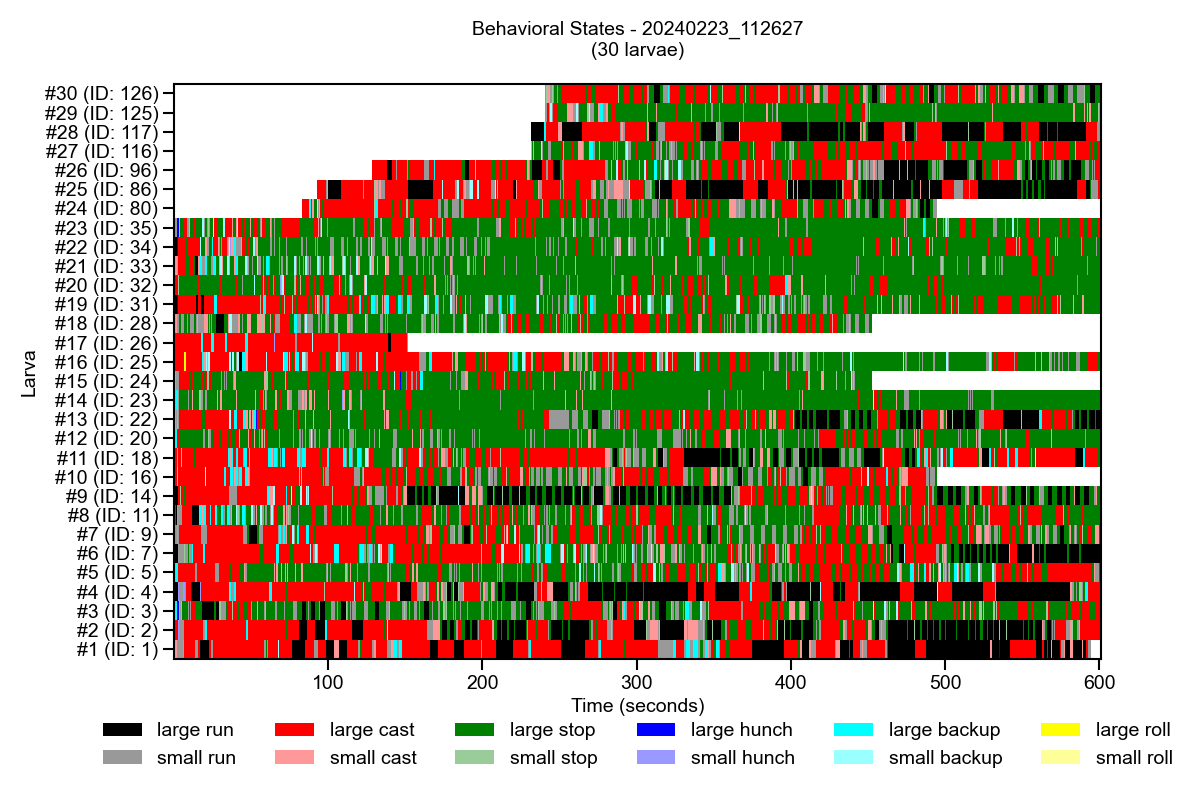

In [8]:
min_total_duration= 300 # seconds (total duration of experiment for anemotaxis is 600 seconds)
trx_filtered_by_duration = preprocessing.filter_larvae_by_duration(trx_data, min_total_duration=min_total_duration)
results_filtered_behavior_matrix = plot_data.plot_global_behavior_matrix(trx_filtered_by_duration)

Excess stop time filtering results (threshold: 50%):
  - Removed 13 larvae with >50% time in stop state
  - 17 larvae remaining


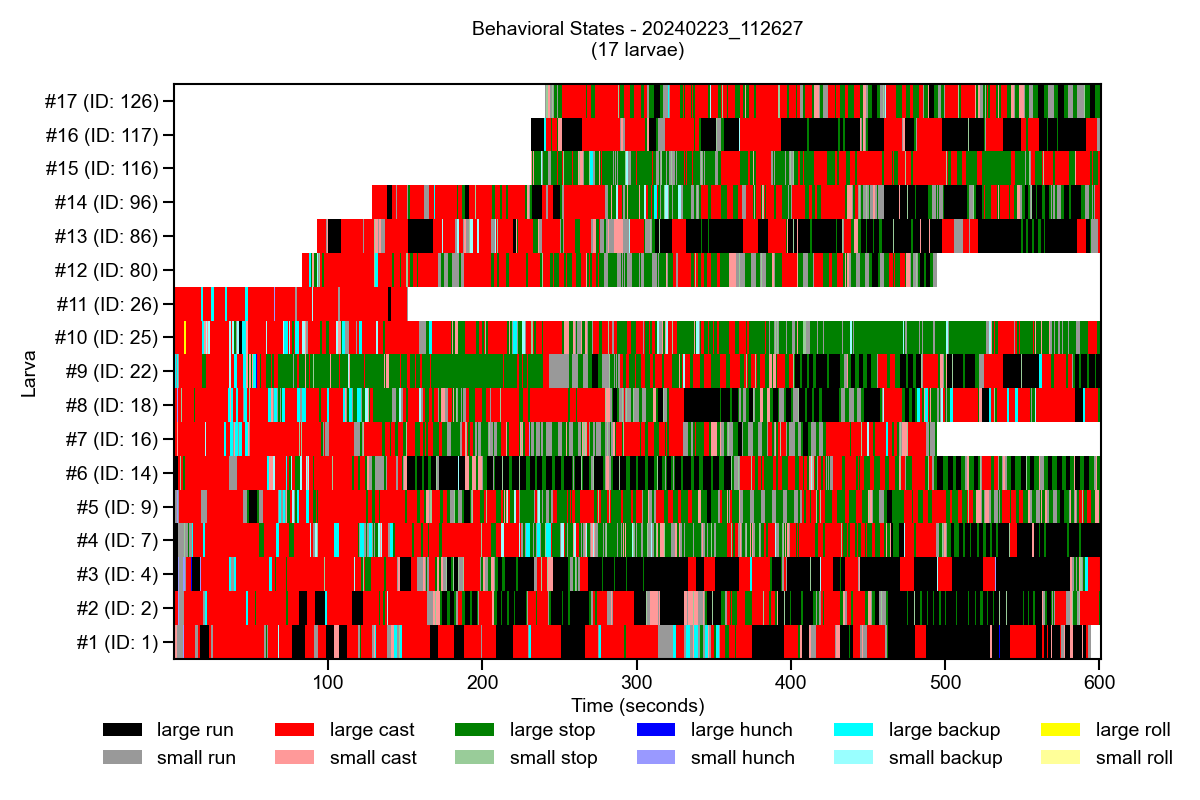

In [14]:
max_stop_percentage = 0.5
trx_filtered_by_removing_stops = preprocessing.filter_larvae_by_excess_stop_time(trx_filtered_by_duration, max_stop_percentage=max_stop_percentage)
results_filtered_behavior_matrix = plot_data.plot_global_behavior_matrix(trx_filtered_by_removing_stops)

Merged 965 sequences with short stops:
  - 379 cast-stop-cast sequences
  - 509 run-stop-run sequences
  - 77 mixed sequences (run-stop-cast or cast-stop-run)
Total duration saved: 997.62 seconds


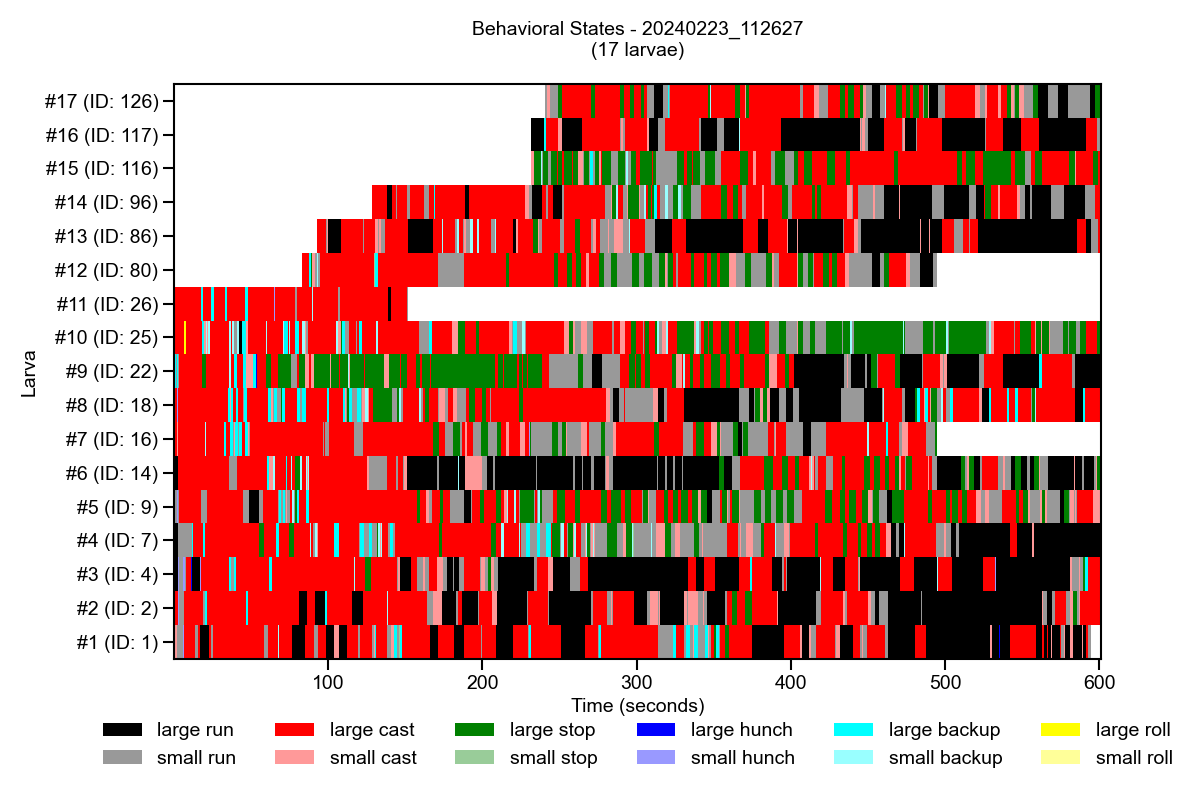

Behavior matrix figure saved to: /Users/sharbat/Projects/anemotaxis/data/FCF_attP2-40@UAS_TNT_2_0003/p_5gradient2_2s1x600s0s#n#n#n/20240223_112627/analyses/behavior_matrix_filtered.pdf


In [15]:
trx_filtered_by_merging = preprocessing.merge_short_stop_sequences(trx_filtered_by_removing_stops, min_stop_duration_cast=2.0, min_stop_duration_run=3.0)
results_merged_behavior_matrix = plot_data.plot_global_behavior_matrix(trx_filtered_by_merging)
fig_behavior = plt.gcf()  # Get current figure
fig_behavior.savefig(os.path.join(output_dir, 'behavior_matrix_filtered.pdf'), 
                    bbox_inches='tight', 
                    dpi=300,
                    transparent=True,
                    facecolor='none')
print(f"Behavior matrix figure saved to: {os.path.join(output_dir, 'behavior_matrix_filtered.pdf')}")

<!-- ## Analysis of one single `trx.mat` file -->

In [45]:
# Analyze run probability by orientation and over time
run_prob_results = data_processor.analyze_run_probability_by_orientation(
    trx_filtered_by_merging, bin_width=10, sigma=2)
    
run_prob_time_results = data_processor.analyze_run_probability_over_time(
    trx_filtered_by_merging, window=60, step=20
)

# Analyze turn probability by orientation and over time
turn_prob_results = data_processor.analyze_turn_probability_by_orientation(
    trx_filtered_by_merging, bin_width=10, sigma=2, min_turn_amplitude=60
)
turn_prob_time_results = data_processor.analyze_turn_probability_over_time(
    trx_filtered_by_merging, window=60, step=20, min_turn_amplitude=60
)

# Analyze backup probability by orientation and over time
backup_prob_results = data_processor.analyze_backup_probability_by_orientation(
    trx_filtered_by_merging, bin_width=10, sigma=2)
backup_prob_time_results = data_processor.analyze_backup_probability_over_time(
    trx_filtered_by_merging, window=60, step=20)


Saved to: /Users/sharbat/Projects/anemotaxis/data/FCF_attP2-40@UAS_TNT_2_0003/p_5gradient2_2s1x600s0s#n#n#n/20240223_112627/analyses


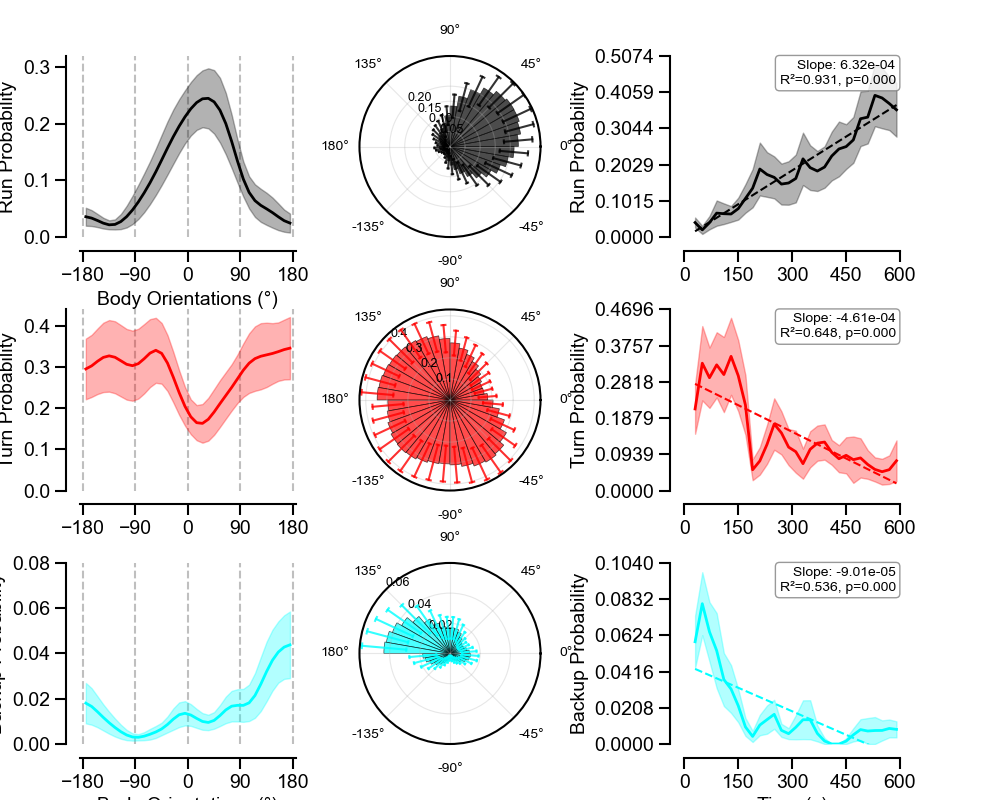

In [46]:
# Create figure with asymmetric spacing - polar plots closer to left
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(3, 3, figure=fig, 
              left=0.08, right=0.90,
              top=0.93, bottom=0.07,
              wspace=0.4,               # Reduced overall spacing
              hspace=0.4,
              width_ratios=[0.6, 0.6, 0.6])  # Left wide, middle narrow, right wide

# Row 1: Run analysis
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], projection='polar')
ax7 = fig.add_subplot(gs[0, 2])


plot_data.plot_orientation_histogram(run_prob_results, plot_type='run', ax = ax1)
plot_data.plot_orientation_histogram_polar(run_prob_results, plot_type='run', ax=ax2, bar_style=True, tick_fontsize=10)
ax2_pos = ax2.get_position()
ax2.set_position([ax2_pos.x0 - 0.04, ax2_pos.y0, ax2_pos.width, ax2_pos.height])


plot_data.plot_metric_over_time(run_prob_time_results, plot_type='run', ax=ax7, show_xlabel=False)


# Row 2: Turn analysis
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1], projection='polar')
ax8 = fig.add_subplot(gs[1, 2])

plot_data.plot_orientation_histogram(turn_prob_results, plot_type='turn', ax=ax3, ylabel='Turn Probability', show_xlabel=False)

plot_data.plot_orientation_histogram_polar(turn_prob_results, plot_type='turn', ax=ax4, bar_style=True, tick_fontsize=10)
ax4_pos = ax4.get_position()
ax4.set_position([ax4_pos.x0 - 0.04, ax4_pos.y0, ax4_pos.width, ax4_pos.height])

plot_data.plot_metric_over_time(turn_prob_time_results, plot_type='turn', ax=ax8, show_xlabel=False)

# Row 3: Backup analysis
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1], projection='polar')
ax9 = fig.add_subplot(gs[2, 2])


plot_data.plot_orientation_histogram(backup_prob_results, ax=ax5, ylabel='Backup Probability', color = 'cyan',show_xlabel=True)

plot_data.plot_orientation_histogram_polar(backup_prob_results, plot_type='backup', ax=ax6, bar_style=True, tick_fontsize=10)
ax6_pos = ax6.get_position()
ax6.set_position([ax6_pos.x0 - 0.04, ax6_pos.y0, ax6_pos.width, ax6_pos.height])
plot_data.plot_metric_over_time(backup_prob_time_results, plot_type='backup', ax=ax9, show_xlabel=True)

fig.savefig(os.path.join(output_dir, 'behavioral_analysis_summary.pdf'), 
            bbox_inches='tight', 
            dpi=300,
            transparent=True,      # Transparent background
            facecolor='none')      # No face color

print(f"Saved to: {output_dir}")

In [ ]:

# Analyze turn amplitude by orientation and over time
turn_amp_results = data_processor.analyze_turn_amplitudes_by_orientation(
    trx_filtered_by_merging, bin_width=20, sigma=0.1, min_turn_amplitude=60
)
turn_amp_time_results = data_processor.analyze_turn_amplitudes_over_time(
    trx_filtered_by_merging, window=60, step=20, min_turn_amplitude=460
)


# Analyze run velocity by orientation and over time
velocity_results = data_processor.analyze_run_velocity_by_orientation(
    trx_filtered_by_merging, bin_width=15, sigma=2
)
velocity_time_results = data_processor.analyze_run_velocity_over_time(
    trx_filtered_by_merging, window=60, step=20
)

Combined velocity & amplitude figure saved to: /Users/sharbat/Projects/anemotaxis/data/FCF_attP2-40@UAS_TNT_2_0003/p_5gradient2_2s1x600s0s#n#n#n/20240223_112627/analyses/velocity_amplitude_analysis.pdf


/Users/sharbat/Projects/anemotaxis/src/viz/plot_data.py:1465: RuntimeWarning: All-NaN slice encountered
  y_min = 60  # Minimum turn amplitude


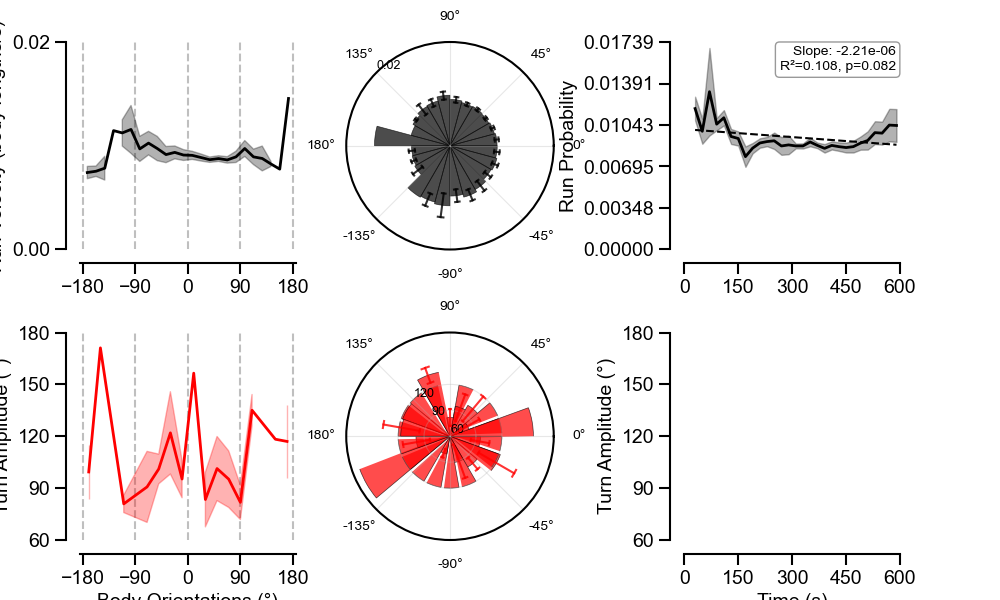

In [40]:
# Create combined figure with asymmetric spacing - polar plots closer to left
fig_combined = plt.figure(figsize=(10, 6))
gs_combined = GridSpec(2, 3, figure=fig_combined, 
                      left=0.08, right=0.90,
                      top=0.93, bottom=0.10,
                      wspace=0.4,               # Reduced overall spacing
                      hspace=0.4,
                      width_ratios=[0.6, 0.6, 0.6])  # Left wide, middle narrow, right wide

# Row 1: Run Velocity Analysis
ax_vel1 = fig_combined.add_subplot(gs_combined[0, 0])
ax_vel2 = fig_combined.add_subplot(gs_combined[0, 1], projection='polar')
ax_vel3 = fig_combined.add_subplot(gs_combined[0, 2])


# Linear plot
plot_data.plot_orientation_histogram(velocity_results, ax=ax_vel1, show_xlabel=False, ylabel='Run Velocity (body lengths/s)')

# Polar plot
plot_data.plot_orientation_histogram_polar(velocity_results, ax=ax_vel2, bar_style=True, tick_fontsize=10)
ax_vel2_pos = ax_vel2.get_position()
ax_vel2.set_position([ax_vel2_pos.x0 - 0.04, ax_vel2_pos.y0, ax_vel2_pos.width, ax_vel2_pos.height])

# Time series plot
plot_data.plot_metric_over_time(
    velocity_time_results, color = 'black',ylabel='Run Velocity (body lengths/s)',
    show_individuals=False, show_error=True, ax=ax_vel3, show_xlabel=False
)

# Row 2: Turn Amplitude Analysis
ax_amp1 = fig_combined.add_subplot(gs_combined[1, 0])
ax_amp2 = fig_combined.add_subplot(gs_combined[1, 1], projection='polar')
ax_amp3 = fig_combined.add_subplot(gs_combined[1, 2])

# Set minimum amplitude
min_amp = 60

# Check if we have ANY valid (non-NaN) data
if turn_amp_results and 'mean_hist' in turn_amp_results:
    mean_hist = np.array(turn_amp_results['mean_hist'])
    has_data = np.any(~np.isnan(mean_hist))
else:
    has_data = False


# Linear plot
plot_data.plot_orientation_histogram(turn_amp_results, ax=ax_amp1, ylabel='Turn Amplitude (°)', 
                                     show_xlabel=True, min_amplitude=min_amp, plot_type='turn_amplitude')

# Polar plot - only if there's valid data
plot_data.plot_orientation_histogram_polar(turn_amp_results, ax=ax_amp2, bar_style=True, 
                                    tick_fontsize=10, min_amplitude=min_amp, plot_type='turn_amplitude')
ax_amp2_pos = ax_amp2.get_position()
ax_amp2.set_position([ax_amp2_pos.x0 - 0.04, ax_amp2_pos.y0, ax_amp2_pos.width, ax_amp2_pos.height])

# Time series plot
plot_data.plot_metric_over_time(
    turn_amp_time_results, plot_type='turn_amplitude', 
    show_individuals=False, show_error=True, ax=ax_amp3, show_xlabel=True,
    min_amplitude=min_amp
)


# Save the combined figure
fig_combined.savefig(os.path.join(output_dir, 'velocity_amplitude_analysis.pdf'), 
                    bbox_inches='tight', 
                    dpi=300,
                    transparent=True,
                    facecolor='none')
print(f"Combined velocity & amplitude figure saved to: {os.path.join(output_dir, 'velocity_amplitude_analysis.pdf')}")

plt.show()

In [ ]:
# Detect head casts with new method
cast_events_data = data_processor.detect_head_casts_in_casts(
    trx_filtered_by_merging,
    peak_threshold=10.0,
    peak_prominence=10.0,
    smooth_sigma=10
)

# Plot with individual subplots
fig = plot_data.plot_cast_detection_results(
    trx_filtered_by_merging,
    cast_events_data,
    figsize=(12,5),
    save_path=os.path.join(output_dir, 'cast_detection_all_larvae.pdf'),
    time_range=None  # Full time range
)

In [ ]:
cast_events_data

In [ ]:
# Export notebook as PDF
from nbconvert import PDFExporter
from IPython.display import Javascript, display
import time

# First, save the notebook automatically
print("💾 Saving notebook...")
display(Javascript('IPython.notebook.save_notebook()'))
time.sleep(2)  # Wait for save to complete

try:
    # Get the current notebook path
    notebook_path = "/Users/sharbat/Projects/anemotaxis/scripts/analyze_single_anemotaxis.ipynb"
    pdf_output_path = os.path.join(output_dir, 'analyze_single_anemotaxis.pdf')
    
    # Export using nbconvert directly
    exporter = PDFExporter()
    (body, resources) = exporter.from_filename(notebook_path)
    
    with open(pdf_output_path, 'wb') as f:
        f.write(body)
    
    print(f"✅ Notebook PDF saved to: {pdf_output_path}")
    
except Exception as e:
    print(f"❌ PDF export failed: {e}")
    print("💡 Alternative: Use Jupyter's File menu > Download as > PDF via LaTeX")

In [ ]:
# Analyze first head cast bias
bias_results_first = data_processor.analyze_first_head_cast_bias_perpendicular(
    cast_events_data, 
    analysis_type='first'
)

# Analyze last head cast bias
bias_results_last = data_processor.analyze_first_head_cast_bias_perpendicular(
    cast_events_data, 
    analysis_type='last'
)

# Analyze all head cast bias
bias_results_all = data_processor.analyze_first_head_cast_bias_perpendicular(
    cast_events_data, 
    analysis_type='all'
)

# Create 1x3 figure layout for all three bias analyses
fig_bias = plt.figure(figsize=(12, 4))
gs_bias = GridSpec(1, 3, figure=fig_bias, 
                   left=0.08, right=0.95,
                   top=0.85, bottom=0.15,
                   wspace=0.3)

# Plot first head cast bias
ax_bias1 = fig_bias.add_subplot(gs_bias[0, 0])
plot_data.plot_head_cast_bias_perpendicular(
    bias_results_first,
    ax=ax_bias1,
    title='First Head Cast Bias'
)
ax_bias1.text(-0.15, 1.05, 'A', transform=ax_bias1.transAxes, 
              fontsize=14, fontweight='bold', va='top', ha='left')

# Plot last head cast bias
ax_bias2 = fig_bias.add_subplot(gs_bias[0, 1])
plot_data.plot_head_cast_bias_perpendicular(
    bias_results_last,
    ax=ax_bias2,
    title='Last Head Cast Bias'
)
ax_bias2.text(-0.15, 1.05, 'B', transform=ax_bias2.transAxes, 
              fontsize=14, fontweight='bold', va='top', ha='left')

# Plot all head cast bias
ax_bias3 = fig_bias.add_subplot(gs_bias[0, 2])
plot_data.plot_head_cast_bias_perpendicular(
    bias_results_all,
    ax=ax_bias3,
    title='All Head Cast Bias'
)
ax_bias3.text(-0.15, 1.05, 'C', transform=ax_bias3.transAxes, 
              fontsize=14, fontweight='bold', va='top', ha='left')

# Save the combined figure
fig_bias.savefig(os.path.join(output_dir, 'head_cast_bias_perpendicular_combined.pdf'), 
                bbox_inches='tight', 
                dpi=300,
                transparent=True,
                facecolor='none')
print(f"Combined head cast bias figure saved to: {os.path.join(output_dir, 'head_cast_bias_perpendicular_combined.pdf')}")

plt.show()

In [ ]:
# Create combined figure for head cast analysis - matching the style of other analysis plots
fig_head_casts = plt.figure(figsize=(10, 4))  # Single row, so height is 4
gs_head_casts = GridSpec(1, 3, figure=fig_head_casts, 
                        left=0.08, right=0.90,
                        top=0.93, bottom=0.15,  # More bottom space for single row
                        wspace=0.4,               
                        width_ratios=[0.6, 0.6, 0.6])

# Row 1: Head Cast Analysis
ax_hc1 = fig_head_casts.add_subplot(gs_head_casts[0, 0])
ax_hc2 = fig_head_casts.add_subplot(gs_head_casts[0, 1], projection='polar')
ax_hc3 = fig_head_casts.add_subplot(gs_head_casts[0, 2])

# Analyze head casts by cast start orientation
head_cast_orientation_results = data_processor.analyze_head_casts_by_orientation(
    trx_filtered_by_merging, 
    bin_width=20, 
    peak_threshold=20.0, 
    peak_prominence=3.0,
    smooth_sigma=4.0,
    large_casts_only=True
)

# Linear plot
plot_data.plot_head_cast_frequency(head_cast_orientation_results,
                                   ylim=[0,8], 
                                  ax=ax_hc1, 
                                  show_xlabel=True, 
                                  ylabel='Head Cast Number')

# Polar plot
plot_data.plot_head_cast_frequency_polar(head_cast_orientation_results, 
                                        ax=ax_hc2, 
                                        bar_style=True, 
                                        tick_fontsize=10)
ax_hc2_pos = ax_hc2.get_position()
ax_hc2.set_position([ax_hc2_pos.x0 - 0.04, ax_hc2_pos.y0, ax_hc2_pos.width, ax_hc2_pos.height])

# Analyze head casts over time
head_cast_time_results = data_processor.analyze_head_casts_over_time(
    trx_filtered_by_merging, 
    window=60, 
    step=20,
    peak_threshold=20.0, 
    peak_prominence=3.0,
    smooth_sigma=4.0,
    large_casts_only=True
)

# Time series plot
plot_data.plot_head_cast_frequency_over_time(
    head_cast_time_results,
    ylabel='Head Cast Rate (per second)',
    show_individuals=False, 
    show_error=True, 
    ax=ax_hc3, 
    show_xlabel=True
)

# Save the head cast analysis figure
fig_head_casts.savefig(os.path.join(output_dir, 'head_cast_analysis.pdf'), 
                      bbox_inches='tight', 
                      dpi=300,
                      transparent=True,
                      facecolor='none')
print(f"Head cast analysis figure saved to: {os.path.join(output_dir, 'head_cast_analysis.pdf')}")

plt.show()

In [ ]:
# 1. Analyze NI over time
ni_time_results = data_processor.analyze_navigational_index_over_time(
    trx_filtered_by_merging, window=60, step=10, t_max=600
)

# 2. Analyze single NI values per larva
ni_single_results = data_processor.analyze_navigational_index_single_values(
    trx_filtered_by_merging, window=60, step=10, t_max=600
)

# 3. Plot time series
fig_time = plot_data.plot_navigational_index_over_time(
    ni_time_results,
    save_path=os.path.join(output_dir, 'ni_over_time.pdf')
)

# 4. Plot box plots
fig_box = plot_data.plot_navigational_index_boxplot(
    ni_single_results,
    save_path=os.path.join(output_dir, 'ni_boxplot.pdf')
)


In [ ]:
# Save all your analysis results
saved_file = data_loader.save_analysis_results(
    output_dir,
    single_path,
    trx_filtered_by_merging,
    # Orientation-based analyses
    run_prob_results=run_prob_results,
    turn_prob_results=turn_prob_results,
    turn_amp_results=turn_amp_results,
    backup_prob_results=backup_prob_results,
    velocity_results=velocity_results,
    
    # Time-based analyses
    run_prob_time_results=run_prob_time_results,
    turn_prob_time_results=turn_prob_time_results,
    turn_amp_time_results=turn_amp_time_results,
    backup_prob_time_results=backup_prob_time_results,
    velocity_time_results=velocity_time_results,
    
    # Head cast analyses
    cast_events_data=cast_events_data,
    bias_results_first=bias_results_first,
    bias_results_last=bias_results_last,
    bias_results_all=bias_results_all,
    head_cast_orientation_results=head_cast_orientation_results,
    head_cast_time_results=head_cast_time_results,

    # NI results
    ni_time_results=ni_time_results,
    ni_single_results=ni_single_results
)

In [ ]:
# Export notebook as PDF
from nbconvert import PDFExporter
from IPython.display import Javascript, display
import time

# First, save the notebook automatically
print("💾 Saving notebook...")
display(Javascript('IPython.notebook.save_notebook()'))
time.sleep(2)  # Wait for save to complete

try:
    # Get the current notebook path
    notebook_path = "/Users/sharbat/Projects/anemotaxis/scripts/analyze_single_anemotaxis.ipynb"
    pdf_output_path = os.path.join(output_dir, 'analyze_single_anemotaxis.pdf')
    
    # Export using nbconvert directly
    exporter = PDFExporter()
    (body, resources) = exporter.from_filename(notebook_path)
    
    with open(pdf_output_path, 'wb') as f:
        f.write(body)
    
    print(f"✅ Notebook PDF saved to: {pdf_output_path}")
    
except Exception as e:
    print(f"❌ PDF export failed: {e}")
    print("💡 Alternative: Use Jupyter's File menu > Download as > PDF via LaTeX")